# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

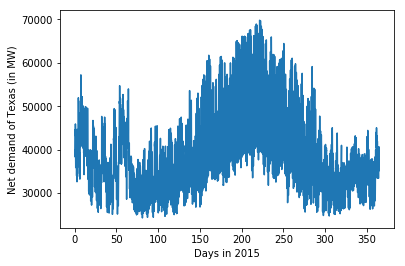

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (5 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Your answer.**
The plot shows us that there is a increase in net demand of power during the 300th day and the beginning of the year along with an increase in net demand of power during the 100th day and 200th day of the year. This implies that Texas climate drastically changes over the year and that the summer tempearture is above than normal as the peak of power demand during summer is higher than the peak during winter. If you plotted the net demand of power for Illinois, the two peaks might be switched as Illinois may have colder winters than Texas and slightly less hotter summers than Texas. 

#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


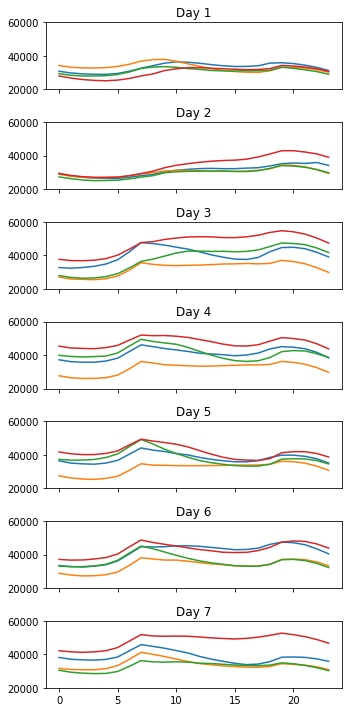

In [12]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (5 points).** Can you find any discernible change in the load profiles of different days of the week?

**Your answer.**
The load profiles on the weekends (Day 1 - Day 2) seemed to be lower compared to the weekdays along with having similar load curves for all 4 weeks. On the weekdays (Day 3 - Day 7), load profile seems to increase within the morning and then can have different variations afterwards (i.e the load profile varies alot on each week). 

**Question (15 points).** Redo the above exercise for the month of August. Make 'Day 1' correspond to August 15th. What do you observe differently? Do your observations agree with Q1? 

**Your answer (comments here, code below).**
The load graph for each of the days all have the same shape and additionally have roughly the same amount of load usage for the entire week. Additionally, many of the load profiles seems to hit 60,000 MW on almost all the days. This could be due to the increase in temperature during the day which could cause residence to consume more power during the day compared to the winter. As stated earlier, the summer for Texas is hotter compared to other states summer so this fits along with our line of assumption made earlier. 

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


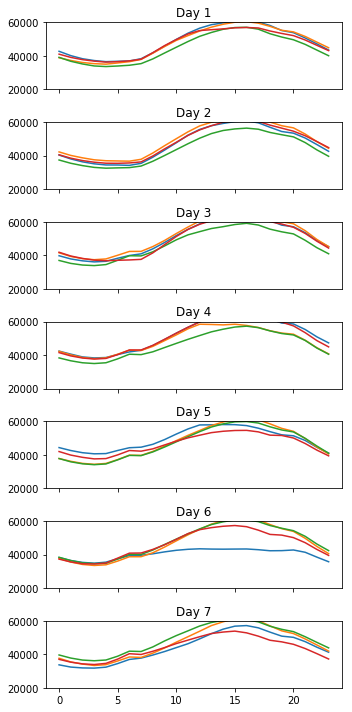

In [15]:
dayStart = 226
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [5]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [6]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

Recall that TensorFlow defines a computation graph where the weights and biases associated with the NN are variables. The goal is to optimize the weights and biases of the NN to minimize prediction error using data. 


To define the computation graph, create the inputs and outputs as 'placeholders'.
The algorithm only expects them to be specified at the time of computation. The
first element of the shape attribute for both inputs and outputs are 'None'. This
means that they are left unspecified, and will be provided at runtime. It will help
in batch training for prediction, where the size of the batch will determine
this value. Batch training is useful because training the NN with one data point at a
time can be time consuming.

In this lab, we begin with a 'relu' activation. We additionally implement 'dropouts' that basically
prevents certain paramters from updating in each round. This is known to prevent overfitting. The number'0.995' in the description below updates 99.5% of all weights, leaving out 0.5%.

Design the optimizer and the loss. For reporting the accuracy of prediction, we choose in this lab the idea of mean absolute error (MAE). For a data set, if the true values are scalars $y_1, \ldots, y_m$ and the predictions are $\hat{y}_1, \ldots, \hat{y}_m$, then its MAE is given by
$$ MAE = \frac{1}{m}\sum|y_i - \hat{y}_i|.$$
If $y$ and $\hat{y}$ are multidimensional, it computes the average across each coordinate of $y$ and $\hat{y}$.

**Question (5 points). Insert a line of code for the output of layer 1 below (use the relu function)** 

In [7]:
nHidden = 100 

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights and biases of the first layer.
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.zeros(nHidden))

# Define the output of layer 1. 
## use the function 'tf.nn.relu' to define 'OutputLayer1'.  

# ....
outputLayer1 = tf.nn.relu( tf.matmul(inputNN, W1) + b1 )
outputLayer1 = tf.nn.dropout(outputLayer1, 0.995)

# Define the weights and biases of the second layer.
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 2.
outputNN = tf.nn.dropout((tf.matmul(outputLayer1, W2) + b2), 0.995)

# Define the loss function and the optimizer.
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.25).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)


### Train the neural network.

Create the training module for the NN. Feed the training data in batches of size 'batchSize'
and ask Tensorflow to run the function 'optimizer'. The number of batches, denoted by 'nBatches'
is then given by the size of your training dataset divided by 'batchSize. Usually, going through
the training data once does not train your NN. You train over the same data multiple
times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn
a material by reading through it once!

In [10]:
print(trainY)

[array([28919, 27474, 26626, 26227, 26338, 27316, 29484, 31898, 32875,
       33905, 34640, 35005, 35138, 35129, 35173, 34875, 34676, 34750,
       37308, 37552, 36790, 36024, 34441, 32372], dtype=int64), array([32989, 31391, 30184, 29291, 29521, 32017, 34227, 35930, 38244,
       41259, 44109, 46676, 49192, 51333, 52790, 54241, 54764, 54094,
       52177, 49952, 48999, 46291, 41780, 37612], dtype=int64), array([41403, 39068, 37644, 36872, 36977, 38514, 39461, 41620, 44927,
       48760, 52545, 56262, 59437, 62174, 63998, 64729, 64933, 64403,
       62652, 59879, 58162, 54962, 50278, 45734], dtype=int64), array([32923, 31207, 29965, 29317, 29891, 32003, 34800, 34022, 35369,
       36849, 38253, 39836, 41795, 43725, 45183, 46352, 46464, 45176,
       42286, 41672, 39719, 37206, 34326, 31490], dtype=int64), array([27183, 26416, 26078, 26317, 27269, 29804, 32982, 33661, 33725,
       34087, 34305, 33908, 33849, 33597, 33056, 32811, 32490, 32216,
       32097, 33366, 33259, 32129, 30492, 2

In [8]:
%%time 
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5000

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch
            print(lossEpoch)
        if (epoch + 1) % 200 == 0:
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch + 1, lossEpoch/nBatches))

    print("Training process completed.")
 

Started the training module.
1723182464.0
3346647424.0
4992666880.0
6554654464.0
8043268480.0
1500164096.0
2873050752.0
4221949568.0
5411734400.0
6548230528.0
1182388992.0
2266648192.0
3311223360.0
4161458880.0
5002254656.0
920537536.0
1778701120.0
2584670912.0
3190117696.0
3827761792.0
734604736.0
1439318464.0
2072694528.0
2516322944.0
3028341120.0
610318848.0
1205964352.0
1738988576.0
2077180736.0
2508036832.0
518535296.0
1048041504.0
1495907904.0
1774221472.0
2167296800.0
474235520.0
960623392.0
1365755808.0
1607169216.0
1985772544.0
443253120.0
907357504.0
1285791936.0
1514737200.0
1871487408.0
413587968.0
857970848.0
1219249952.0
1435562176.0
1788415168.0
396973760.0
826366176.0
1173407072.0
1379406176.0
1732202624.0
383271360.0
816631968.0
1162268800.0
1372502576.0
1723859600.0
383841248.0
802717376.0
1140032192.0
1340076464.0
1686926608.0
374782176.0
791240416.0
1120385760.0
1318517248.0
1665030016.0
371634080.0
783403552.0
1114876608.0
1312105392.0
1659603856.0
363173632.0
7813

531411040.0
758279120.0
879303712.0
1122373488.0
234005024.0
536406464.0
765760240.0
884137560.0
1128218776.0
227985184.0
528897184.0
751452368.0
861631368.0
1107290792.0
222512640.0
520919136.0
745021232.0
855782640.0
1103796256.0
221974528.0
519739104.0
740858640.0
858829792.0
1102185440.0
226243440.0
520880656.0
748287008.0
869612096.0
1112512272.0
225288656.0
516433360.0
742760704.0
859192968.0
1099122168.0
220045392.0
518747664.0
740303984.0
850219656.0
1088485176.0
223263232.0
517504256.0
739250848.0
860293312.0
1097472928.0
227299136.0
516841056.0
736806688.0
850559680.0
1095553296.0
213682560.0
505065120.0
728664976.0
836903208.0
1081280728.0
217458448.0
512083504.0
724645424.0
831921128.0
1076676840.0
220088704.0
507502304.0
727167328.0
835859248.0
1068946720.0
211278016.0
495166112.0
706048944.0
810423264.0
1049411376.0
221883088.0
512767248.0
730013712.0
842974648.0
1077873320.0
214424208.0
498404624.0
711810512.0
816974736.0
1055663232.0
206151136.0
490404160.0
710943104.0


87345928.0
194657784.0
292152520.0
354355156.0
475245076.0
88156184.0
195939120.0
289870048.0
362120024.0
477532320.0
81140328.0
185445488.0
279939624.0
345040464.0
466787416.0
85184704.0
191149864.0
289111408.0
355342164.0
475234444.0
85815296.0
191213312.0
287565200.0
352362104.0
466993512.0
82062752.0
190674440.0
286036144.0
353743792.0
462579032.0
78853968.0
187175680.0
286519120.0
355570288.0
470286688.0
78265904.0
185798216.0
281815552.0
339626948.0
448553292.0
86564176.0
193346320.0
285100872.0
342978744.0
456875280.0
84203264.0
184867272.0
290509560.0
346444548.0
458168916.0
81835312.0
186394736.0
276394696.0
335831944.0
450208064.0
74334960.0
174550552.0
272357880.0
337169836.0
443235268.0
78975888.0
178885832.0
273251672.0
338437308.0
447942244.0
76726888.0
179422864.0
272651696.0
344075688.0
463501448.0
73171560.0
172329072.0
258022264.0
325136984.0
434479216.0
77172528.0
176459816.0
268263976.0
334854424.0
442951784.0
79121208.0
188647400.0
280447880.0
340051220.0
448678900

55313728.0
119063872.0
194038352.0
249486192.0
336337544.0
50828060.0
110741728.0
177754840.0
220250536.0
297831504.0
60440588.0
120137548.0
184810492.0
228424420.0
301381908.0
50988396.0
112763284.0
177718076.0
220033232.0
290492288.0
62628176.0
122187100.0
187286120.0
229681176.0
303554544.0
54998864.0
116036692.0
184387828.0
226129556.0
297598476.0
64316116.0
121383636.0
188269500.0
232077536.0
304240456.0
52570816.0
110537052.0
179622596.0
225056928.0
300677440.0
50023976.0
109601744.0
188125872.0
233111456.0
307021592.0
54516740.0
114500816.0
176099536.0
219946780.0
294956948.0
51914572.0
113574828.0
179863200.0
224531268.0
295662500.0
61045584.0
117530572.0
184828372.0
223620784.0
291577872.0
49498320.0
109868780.0
180689484.0
219535676.0
287677228.0
54977556.0
116193688.0
179301516.0
227317272.0
296243712.0
49193008.0
111098668.0
175448864.0
220589728.0
296915464.0
52054400.0
111708624.0
173310348.0
209394800.0
279135416.0
55496112.0
115106212.0
179622452.0
227673448.0
295319464

245693376.0
42354312.0
88381112.0
149586952.0
186434196.0
243224868.0
46425860.0
89517468.0
141941384.0
172252296.0
226806340.0
55346612.0
108568276.0
160490928.0
195161476.0
247239972.0
46455644.0
98506156.0
155673156.0
189754164.0
248257768.0
46208852.0
96523544.0
149831536.0
181733270.0
243443586.0
49450312.0
100692632.0
163048784.0
202112284.0
262211336.0
47703456.0
95852884.0
156547728.0
189519220.0
249107584.0
Epoch: 600 - Average loss in last epoch = 49821516.8
47085532.0
91794388.0
148841392.0
191857520.0
251475100.0
51844600.0
96984832.0
150606324.0
188852792.0
243821344.0
48423176.0
98801272.0
154625084.0
188908160.0
255817916.0
42811724.0
96573952.0
145183172.0
180620444.0
232147144.0
45482088.0
98537804.0
151488028.0
185761772.0
243445180.0
48086288.0
91229448.0
145158648.0
185029520.0
252181600.0
50193328.0
98208876.0
148443076.0
180422026.0
236392650.0
47037948.0
95608404.0
153360120.0
190564088.0
251443688.0
46680196.0
90181756.0
142862064.0
178917992.0
235567584.0
50162

88621732.0
135016980.0
165879964.0
219094272.0
44759512.0
88555980.0
130111260.0
160696038.0
215232938.0
41701572.0
84038476.0
129440740.0
155813042.0
208647630.0
48775456.0
92052688.0
132397496.0
169552708.0
226674996.0
47618964.0
93010196.0
137493028.0
173283748.0
226704532.0
36858336.0
77845568.0
133728532.0
168523820.0
220239456.0
40999964.0
78988956.0
128645056.0
167720220.0
221586764.0
45821760.0
88154372.0
127317636.0
161651360.0
216036268.0
40806508.0
78891756.0
118709060.0
152645724.0
202611488.0
36437356.0
77841204.0
130013568.0
160082646.0
211679298.0
37847080.0
78350096.0
121471492.0
155369188.0
206057628.0
38069284.0
82130432.0
125442328.0
158341708.0
211308060.0
38288244.0
75644708.0
126315384.0
153329374.0
207938762.0
47139656.0
89456180.0
128877840.0
161268536.0
210867872.0
42649660.0
82123220.0
123099872.0
155253838.0
205893978.0
36638012.0
76070472.0
118799064.0
158266052.0
207033640.0
40056364.0
79497924.0
126158888.0
160385800.0
224491468.0
45809752.0
84178644.0
133

66966688.0
104914100.0
132088094.0
173936182.0
36266912.0
79065880.0
114482060.0
145137742.0
193912898.0
39575100.0
71580292.0
106469240.0
142504636.0
186341112.0
31464072.0
67049728.0
103546868.0
131408778.0
183664058.0
34536332.0
77101752.0
122791720.0
152827442.0
201386210.0
34875428.0
74524376.0
111875560.0
146339796.0
193689448.0
37544884.0
75286624.0
125228996.0
155029902.0
196799282.0
35063216.0
71219872.0
114779556.0
143847028.0
188525532.0
33181246.0
69521798.0
117120130.0
148294496.0
193636332.0
32502238.0
71425134.0
115326958.0
151022470.0
195523030.0
40256128.0
79242288.0
112984964.0
141475106.0
187714158.0
36192664.0
75149660.0
117755200.0
143060804.0
190195688.0
36801400.0
74042252.0
118690148.0
142531942.0
189798678.0
33629888.0
69065304.0
108768220.0
137654870.0
179909566.0
36658080.0
74533648.0
117728004.0
139367332.0
184478928.0
38989432.0
73531616.0
111088816.0
135893532.0
182431596.0
42059204.0
77204588.0
117482304.0
150200972.0
193082052.0
37833564.0
74333464.0
120

39462204.0
68651772.0
104567956.0
133622874.0
181138442.0
33000246.0
63782048.0
97005120.0
127007842.0
170089890.0
41249160.0
73051330.0
108277982.0
136817816.0
183409024.0
34658692.0
71927880.0
108730404.0
147481516.0
186859228.0
31542566.0
63948432.0
99699644.0
125140606.0
175302398.0
27276476.0
57966650.0
102522550.0
137227202.0
180488978.0
33043916.0
67991340.0
103981712.0
131710264.0
181009616.0
32110728.0
64375426.0
99821302.0
131229290.0
175658078.0
36371980.0
66048646.0
102026410.0
135293112.0
179112668.0
36054004.0
68123690.0
105542242.0
142726834.0
185070426.0
31594236.0
62129226.0
94608496.0
118305256.0
156177864.0
40409408.0
75030508.0
116545100.0
138027846.0
177063810.0
31264134.0
71117598.0
106681126.0
135589458.0
179781982.0
30365610.0
60969434.0
104105482.0
134135374.0
174234674.0
32620162.0
66488626.0
109627214.0
138278092.0
181957896.0
48047316.0
78893030.0
109441026.0
143822594.0
183450118.0
37005296.0
66408104.0
104564536.0
137041556.0
178984128.0
34371428.0
7143259

27034878.0
57506950.0
89104054.0
122037464.0
162873884.0
31575860.0
57781062.0
92410286.0
122286708.0
161337920.0
27601110.0
53869538.0
86303150.0
111059692.0
150888292.0
32338996.0
62710304.0
98764516.0
131769920.0
168774652.0
31416242.0
65041898.0
93869006.0
116581668.0
153035528.0
22965586.0
51838822.0
82037224.0
106089040.0
146157292.0
32241192.0
61776008.0
95758260.0
126206698.0
168118014.0
24606402.0
56896850.0
89603670.0
116267946.0
152717098.0
30384074.0
69178014.0
104759890.0
131182004.0
170384524.0
34111552.0
65442310.0
101450282.0
127902174.0
174444366.0
26462370.0
53250412.0
92844664.0
119829170.0
157954178.0
24356574.0
58709414.0
91614292.0
114929300.0
154063316.0
28125414.0
57584126.0
91366434.0
121182184.0
157760652.0
31928798.0
62598642.0
95556294.0
115688848.0
158067428.0
34473184.0
59598226.0
96126238.0
124121558.0
164532114.0
32766702.0
63325336.0
94220108.0
118302204.0
165172512.0
26672952.0
51556960.0
88083696.0
111632352.0
150325036.0
28604584.0
57671810.0
8599902

119290992.0
154530064.0
27301448.0
52449646.0
88950834.0
126791810.0
165325290.0
24705492.0
54605630.0
82669310.0
111203964.0
151825972.0
24901176.0
56155676.0
85046000.0
110596382.0
147105442.0
26263450.0
53632940.0
85874576.0
106792646.0
143569922.0
25392820.0
50908172.0
78301162.0
101940710.0
135519690.0
25812924.0
51204810.0
77138064.0
112276636.0
152236408.0
29510622.0
63464538.0
95425660.0
122364074.0
155222398.0
33196714.0
60191754.0
93026618.0
117564474.0
151665114.0
24473986.0
50985584.0
81374276.0
106596216.0
146949424.0
21919114.0
51378020.0
77214742.0
107283372.0
146855320.0
29630888.0
58979056.0
83989488.0
116115818.0
152382094.0
32085242.0
60248180.0
89587930.0
114810572.0
150807864.0
30481496.0
55446258.0
85751388.0
109179966.0
143373782.0
27305222.0
52713844.0
88922260.0
115369270.0
160207726.0
28253792.0
58113394.0
91340338.0
111390398.0
147599810.0
29734080.0
54009728.0
82138560.0
111813548.0
143968342.0
29967982.0
61779094.0
92016606.0
113871900.0
160953380.0
3073955

89547728.0
115307396.0
153983884.0
23349436.0
56901800.0
89123926.0
117014966.0
154681414.0
31024156.0
59965492.0
85331102.0
106596614.0
145962966.0
28248626.0
55074718.0
85527850.0
110349670.0
146865286.0
22207918.0
48637610.0
78265404.0
101904212.0
140660528.0
40106508.0
68068384.0
101039828.0
125487722.0
160544582.0
39813960.0
65507764.0
95100360.0
119303182.0
160161646.0
30782024.0
62953374.0
89351272.0
118073434.0
153479454.0
21985264.0
46115074.0
72503134.0
97192438.0
133465098.0
24692938.0
58765138.0
91840908.0
116287382.0
154722978.0
22911280.0
55054272.0
80693268.0
103569212.0
133076632.0
29119986.0
55526010.0
94025446.0
113843412.0
146761052.0
26763866.0
57127380.0
84090344.0
107570180.0
143755464.0
28585192.0
51977386.0
83569888.0
102271998.0
141957594.0
22918588.0
49032186.0
84004918.0
102522486.0
138263942.0
32486884.0
58354256.0
95421048.0
120627558.0
156844262.0
20273114.0
48918162.0
78902558.0
110754630.0
145480810.0
25940138.0
57245740.0
82211286.0
103974798.0
13493741

76863030.0
98942422.0
133427682.0
26199050.0
54266010.0
88867706.0
106374434.0
141001554.0
33778728.0
57141888.0
89244038.0
110748968.0
142506642.0
29158984.0
52527164.0
81037986.0
101974376.0
146502564.0
27421672.0
52040534.0
84457114.0
106009178.0
140432590.0
26170746.0
56783406.0
87867578.0
111821900.0
143607400.0
23298608.0
42684778.0
76382258.0
105818862.0
139335214.0
25787230.0
60421294.0
86601206.0
112589788.0
152982712.0
27888238.0
55375186.0
77593448.0
103727272.0
132869766.0
34292100.0
57864912.0
87304196.0
124705716.0
163299160.0
31274510.0
63662060.0
95975568.0
117203296.0
150649832.0
26772174.0
51634556.0
87746044.0
109070348.0
142867636.0
22470814.0
44835450.0
70556636.0
88174442.0
124483586.0
23729514.0
50261472.0
77548970.0
102031800.0
135399136.0
28555202.0
64178538.0
89401222.0
113534514.0
153477578.0
22751178.0
47387452.0
77468534.0
99239630.0
131643032.0
31265762.0
59802310.0
91148128.0
116409848.0
143950874.0
19813410.0
41815418.0
68462510.0
95162228.0
129708536.0


109646102.0
142900628.0
21346914.0
49553804.0
78791800.0
101652088.0
135961668.0
Epoch: 1800 - Average loss in last epoch = 27192333.6
25563430.0
49151508.0
81389066.0
98035394.0
126425696.0
24029096.0
48449058.0
77520274.0
96663544.0
127884512.0
21107810.0
39953642.0
68095282.0
90790840.0
129307192.0
27377138.0
55677280.0
90119724.0
113474398.0
145850916.0
18544438.0
48659554.0
75366958.0
95497302.0
132726394.0
26874682.0
50389996.0
75260750.0
93695066.0
121999624.0
24945328.0
49245078.0
79774034.0
105342938.0
133504484.0
25508290.0
53300380.0
76142750.0
102874066.0
134329968.0
19528042.0
42413960.0
73938394.0
95906894.0
129198308.0
26396966.0
57386388.0
89693574.0
108213798.0
138834292.0
26838920.0
52150752.0
84237996.0
103929530.0
137334902.0
23343762.0
53367442.0
79870250.0
103933106.0
139171470.0
28495258.0
52706760.0
78862378.0
104613124.0
138573648.0
21898226.0
47508606.0
72611668.0
98456972.0
131272834.0
24829474.0
59774922.0
89065018.0
111218996.0
142241848.0
25160970.0
453425

19510744.0
39367066.0
68602976.0
85536460.0
112500434.0
22960600.0
41738636.0
65935668.0
95566774.0
127388858.0
25468938.0
48386730.0
78051996.0
98588866.0
122959770.0
22365682.0
41212574.0
64593328.0
90102702.0
124924974.0
23851870.0
43611128.0
73657158.0
97526198.0
126997314.0
23055910.0
47759102.0
74342056.0
95489762.0
124634884.0
24197146.0
47001062.0
76763366.0
97115442.0
125861978.0
26832664.0
48696118.0
79539982.0
100743204.0
133861152.0
28717302.0
60271224.0
89058998.0
111195054.0
144412768.0
16908922.0
35765702.0
59585414.0
76499512.0
110522672.0
27601810.0
50508542.0
79500672.0
105912356.0
137676004.0
28642260.0
51574734.0
75960342.0
103927156.0
136765320.0
23641176.0
43579890.0
73449680.0
99969336.0
131209904.0
18587198.0
43468492.0
66432368.0
97917092.0
127646494.0
20907060.0
45808550.0
76048014.0
97932362.0
128209360.0
23013592.0
48485216.0
81086376.0
102471632.0
139219184.0
26310970.0
53491988.0
80410286.0
103594966.0
130379364.0
26369314.0
53360504.0
83838498.0
106551174

123733594.0
22666230.0
43142284.0
63068962.0
89265544.0
121434442.0
22629404.0
42676402.0
68630396.0
91670942.0
119624310.0
24599160.0
46142404.0
70741012.0
89247508.0
115413272.0
27088564.0
43485852.0
69534622.0
89202108.0
115362028.0
24602586.0
48922576.0
75524134.0
92340744.0
119618708.0
17926418.0
40085262.0
61635010.0
82985536.0
106606752.0
19224122.0
44900618.0
68097096.0
87260170.0
113245506.0
20573790.0
44022784.0
70041620.0
90183020.0
118255016.0
26352022.0
49003978.0
82623758.0
103776240.0
134186282.0
25419866.0
44557188.0
69771222.0
88184992.0
125102088.0
29926550.0
50066808.0
71670362.0
91648664.0
120247584.0
26860554.0
45071858.0
67624400.0
88997372.0
117859150.0
27119816.0
55471128.0
76230952.0
96568104.0
126293766.0
24316918.0
45482096.0
67780700.0
85583772.0
119836276.0
18448896.0
48487792.0
75797446.0
91278908.0
118278296.0
18308010.0
46003194.0
65726930.0
79092729.0
103971475.0
24809524.0
46144318.0
73963820.0
89680493.0
131127069.0
19176582.0
46846396.0
74093164.0
10

68468240.0
84356585.0
114272301.0
22663752.0
45961482.0
74632946.0
96354360.0
127996782.0
17250946.0
40946896.0
67899008.0
95527372.0
121339986.0
23352802.0
41855640.0
60516370.0
89611644.0
121871548.0
20213374.0
40214774.0
71014762.0
93280702.0
123902064.0
27655530.0
44498766.0
71906048.0
93293492.0
118093986.0
25168608.0
51959386.0
78408892.0
100197930.0
122612048.0
22751482.0
49244884.0
71492952.0
89027012.0
118719094.0
20566354.0
49476332.0
78687314.0
96685588.0
118332364.0
28091922.0
48121972.0
74277812.0
95609988.0
124605436.0
27474912.0
46930394.0
79234922.0
100856932.0
125896534.0
19575592.0
47224470.0
69981956.0
90879020.0
113474424.0
23620366.0
46246302.0
77819554.0
106905154.0
131149268.0
26263902.0
48185560.0
71411822.0
90368972.0
118358012.0
25550886.0
51041308.0
76911376.0
97927974.0
123331646.0
22416602.0
49386926.0
72296874.0
93809204.0
117934644.0
17562064.0
42457794.0
74098958.0
98026240.0
123574982.0
36154484.0
56379270.0
87844434.0
108823956.0
136121482.0
19922138.0

67385154.0
89562502.0
118990156.0
22897886.0
44541992.0
66927570.0
84606156.0
109931734.0
22204838.0
43169562.0
71590688.0
94045878.0
116041392.0
17402866.0
38131344.0
58284716.0
83403512.0
108498790.0
34188248.0
57702034.0
84844878.0
110265862.0
137287694.0
18053986.0
42712848.0
64907314.0
84130138.0
114495374.0
21010588.0
45203246.0
67029984.0
88482946.0
114557678.0
17047500.0
45675798.0
68817458.0
89549746.0
114590902.0
16102043.0
43034617.0
59704581.0
78626783.0
108641439.0
23555570.0
50368840.0
83458942.0
105686852.0
130407492.0
15009393.0
36143285.0
59730259.0
86585121.0
118570775.0
24496858.0
40906366.0
63950332.0
87253630.0
118104900.0
20896406.0
47248432.0
76282566.0
98567512.0
133191408.0
27884582.0
48339406.0
71141996.0
95404946.0
119963296.0
24650568.0
44995730.0
74538010.0
99202368.0
128907642.0
21245898.0
40739346.0
67556568.0
87468450.0
114535684.0
22484562.0
38822376.0
60046608.0
78218878.0
105629672.0
25603236.0
42972528.0
66960314.0
91892904.0
119848026.0
22031446.0
4

85001182.0
105811824.0
21137770.0
50295658.0
82327654.0
101281000.0
132468394.0
21629422.0
45347608.0
71588584.0
93130298.0
118859302.0
17362930.0
37217584.0
57494368.0
74328058.0
98729130.0
18966796.0
43938322.0
61655594.0
84033612.0
103866732.0
22225646.0
43719436.0
76683478.0
98421968.0
118219138.0
19844434.0
36189918.0
60447830.0
79050956.0
109691418.0
19303628.0
40978604.0
64387610.0
84882494.0
111406802.0
17030260.0
42258814.0
65491632.0
84042726.0
107244080.0
19414732.0
37119778.0
65485602.0
79351592.0
104437648.0
22922864.0
43361314.0
65108114.0
88931476.0
111507136.0
24099580.0
46669418.0
67042072.0
79417497.0
101371235.0
18658832.0
48108740.0
69435840.0
89585828.0
115676298.0
23743994.0
45939758.0
70529104.0
91045262.0
111473222.0
17147594.0
38673932.0
61002110.0
82131622.0
111450156.0
23503960.0
40511756.0
70038468.0
92064886.0
115459630.0
28047000.0
47870886.0
73969252.0
94920982.0
120818440.0
23364544.0
39416809.0
65687573.0
85736649.0
111151915.0
18922892.0
40286804.0
659

28476484.0
46509688.0
67029910.0
89478638.0
107543370.0
15123268.0
32844246.0
61012432.0
85214946.0
113793736.0
19673176.0
46765164.0
65220628.0
84730978.0
108122862.0
16502013.0
42376285.0
64169777.0
82505843.0
113193557.0
16382094.0
36631102.0
61803090.0
83552444.0
105270906.0
24428004.0
42913234.0
64298512.0
87405550.0
110904292.0
22230042.0
48903502.0
67493038.0
88744464.0
117343986.0
24784578.0
45721372.0
68297550.0
82483780.0
112557186.0
23657084.0
43392026.0
71762950.0
85550868.0
107910332.0
20991126.0
39822404.0
62283012.0
88603928.0
113054998.0
20242494.0
41170930.0
66390412.0
82424957.0
108185117.0
15286007.0
32469069.0
55317379.0
74963517.0
95791705.0
20073696.0
39193850.0
64540300.0
82793240.0
109139358.0
23739454.0
46515620.0
75643488.0
92907588.0
109885778.0
16393743.0
31313553.0
50434217.0
67462727.0
87763953.0
19150688.0
39118962.0
61801060.0
83626140.0
104544688.0
14934419.0
39181627.0
57579589.0
79847411.0
110351145.0
25096830.0
50220726.0
72493790.0
88086397.0
116711

26404826.0
49193018.0
70001088.0
84736762.0
113694196.0
17496312.0
38825012.0
67348294.0
91607512.0
121593420.0
20542290.0
35461620.0
61774466.0
74134733.0
95569689.0
19249828.0
37195792.0
61048438.0
78278664.0
104370352.0
21220878.0
51249044.0
70267802.0
90524666.0
116742110.0
19721670.0
46856288.0
64143316.0
88724844.0
119812706.0
23291436.0
46945796.0
68365960.0
92039648.0
115373794.0
19498144.0
45321144.0
68617230.0
84803760.0
107759140.0
21107108.0
38690376.0
59194832.0
85512968.0
107529764.0
15939663.0
34458031.0
57656799.0
75836281.0
99678541.0
21559490.0
42243120.0
67805952.0
83747540.0
104609382.0
18801602.0
34980078.0
58191220.0
76983244.0
106771490.0
14651646.0
31475212.0
53924048.0
81963174.0
99609830.0
15521289.0
40604871.0
62916147.0
87208339.0
111216059.0
13396501.0
29345523.0
53359099.0
67285704.0
90513544.0
19243284.0
39893462.0
60145052.0
82756150.0
113626944.0
23652946.0
40459728.0
59928162.0
75023588.0
95710962.0
24061760.0
40925274.0
60808374.0
79166176.0
104139790

37434954.0
58277442.0
72331490.0
103622090.0
23130976.0
42610108.0
63580824.0
89728122.0
111322030.0
21101062.0
38226346.0
59509442.0
79762374.0
101410464.0
22905636.0
38503508.0
58149572.0
82122262.0
101588206.0
33630872.0
48599177.0
78402899.0
99422799.0
129086051.0
18974342.0
31693804.0
48900390.0
69921336.0
93288098.0
17964074.0
43688674.0
61407974.0
76337440.0
99394504.0
19100286.0
35553384.0
62205258.0
88240856.0
109872736.0
17936034.0
35437454.0
56422630.0
75948234.0
103268244.0
17578830.0
32905794.0
56280186.0
74980250.0
95418652.0
20794828.0
43707694.0
63159786.0
79205363.0
102173827.0
20019438.0
39540868.0
65300134.0
83032862.0
102187718.0
18501312.0
37115714.0
58715790.0
70901700.0
88837730.0
20964720.0
39607258.0
61818412.0
78396808.0
94080699.0
18170414.0
39832624.0
63504616.0
78548476.0
101344322.0
21247392.0
39274182.0
61473274.0
79368852.0
101718414.0
19252194.0
37247534.0
59288286.0
73659518.0
94486648.0
18248472.0
34674309.0
57579195.0
78481427.0
98231447.0
19653186.0

65590570.0
85011652.0
22994382.0
38621189.0
63763805.0
76722515.0
95883279.0
13569910.0
34738360.0
61323892.0
82828792.0
103238948.0
19091102.0
37858862.0
56447586.0
74456922.0
87811012.0
21665724.0
39226100.0
59620320.0
79060674.0
93213742.0
21878976.0
39105938.0
59092422.0
80387788.0
101486494.0
30766810.0
51508640.0
72218612.0
89641046.0
108733078.0
18651498.0
35248012.0
61823144.0
81493870.0
99550136.0
21581612.0
43600722.0
67731696.0
84763592.0
115250472.0
16404630.0
38836964.0
55487248.0
71366068.0
95332660.0
12150953.0
26033993.0
49757519.0
67623691.0
88146007.0
20652332.0
44164278.0
68684962.0
81790638.0
103773830.0
Epoch: 3200 - Average loss in last epoch = 20754766.0
18934876.0
38809842.0
55708348.0
68858669.0
91256853.0
23021534.0
43353126.0
64348262.0
83739782.0
105319912.0
24595978.0
47047382.0
71160464.0
87867587.0
108703603.0
19668292.0
43263446.0
66839326.0
83071858.0
99212487.0
14105875.0
30540375.0
53227553.0
72524639.0
92224471.0
21371154.0
42651590.0
59309437.0
7858

18040430.0
38436184.0
60863244.0
74894999.0
101763187.0
23056122.0
46634518.0
66016820.0
79813453.0
100435899.0
17405078.0
36762018.0
53575528.0
69387682.0
85157070.0
15840635.0
34188841.0
56206165.0
77427733.0
96753267.0
16885884.0
31525495.0
55038243.0
70303081.0
86789116.0
13487998.0
31322846.0
56816886.0
74653802.0
91989090.0
20492698.0
34577905.0
56903741.0
80106661.0
102907993.0
18555782.0
34586625.0
53575215.0
72647005.0
99168769.0
24528734.0
49889998.0
80161492.0
98894216.0
118291056.0
18147424.0
37584242.0
59208218.0
77168536.0
99416246.0
14015848.0
33220666.0
54967338.0
79876272.0
97045858.0
18603340.0
37447584.0
57981568.0
73273735.0
98540475.0
18144222.0
38043964.0
55637352.0
77648372.0
96300528.0
19184076.0
37956874.0
55786346.0
79355282.0
108939004.0
14775733.0
32029973.0
55492041.0
73100021.0
92970517.0
20759528.0
33742209.0
60545217.0
80046803.0
104285343.0
16376753.0
31306837.0
53585233.0
71124849.0
92270469.0
21541522.0
37461176.0
57022560.0
71232204.0
99749260.0
1458

43971486.0
55665098.0
79138460.0
99828356.0
13226708.0
31626248.0
56466964.0
74831630.0
101186278.0
18440314.0
36676098.0
58541966.0
76924656.0
97552036.0
18377680.0
42734874.0
62569136.0
79687052.0
94956141.0
26582616.0
44006162.0
65946730.0
84545938.0
107270846.0
17222650.0
42049468.0
63279826.0
77925071.0
95146517.0
23229652.0
39307237.0
59562751.0
81893917.0
101409957.0
16572218.0
32815456.0
59400864.0
72999772.0
93642704.0
21962724.0
37049232.0
60158404.0
74617136.0
89058343.0
12972307.0
26166641.0
41469913.0
55045520.0
73367054.0
20923396.0
41807486.0
70271270.0
88439922.0
110537134.0
25395698.0
37679318.0
63759758.0
78738663.0
98504331.0
18179834.0
33337983.0
51218631.0
69502273.0
90402909.0
15181145.0
32143025.0
56462019.0
70402685.0
90746347.0
11843617.0
28902259.0
50689497.0
66806477.0
85323859.0
17471110.0
41033596.0
76336284.0
98367958.0
114425077.0
25437084.0
43647184.0
59584408.0
79959550.0
104037120.0
29690116.0
45304495.0
64048087.0
83562569.0
102402513.0
19931776.0
430

18449836.0
35708916.0
54193748.0
68455709.0
90027543.0
18932072.0
36384744.0
54700824.0
79415462.0
107357646.0
21180932.0
44256702.0
62642336.0
80104850.0
98376798.0
21794734.0
34323167.0
58063743.0
73803307.0
95936089.0
23593690.0
41923628.0
61667420.0
83375106.0
102325848.0
27692770.0
43308784.0
69070256.0
81190277.0
98626675.0
19956934.0
35552230.0
48933361.0
67489599.0
85052053.0
19955042.0
37655814.0
55682138.0
75680476.0
90719500.0
19111882.0
45955734.0
69221658.0
84527959.0
105613085.0
17685184.0
41770030.0
63120278.0
84744460.0
105673466.0
20737888.0
36326189.0
50036179.0
63199714.0
83515868.0
18840256.0
43101894.0
62526860.0
80802850.0
101711022.0
14360950.0
28254329.0
53823681.0
72964337.0
89996657.0
26760786.0
38360632.0
57319964.0
74184748.0
91452634.0
15390961.0
30809920.0
48477044.0
64706389.0
77676340.0
11821483.0
29718833.0
53534731.0
66122860.0
78350455.0
18905942.0
42712572.0
65413658.0
84881520.0
103282496.0
14640705.0
29782025.0
52119125.0
71464595.0
97350617.0
1243

55982254.0
78545518.0
97029414.0
26348998.0
38773830.0
63872472.0
81337390.0
98482260.0
22306730.0
40117602.0
53811295.0
68808787.0
80984182.0
19280164.0
42551816.0
60978406.0
78313694.0
93715640.0
12006985.0
29802795.0
47911833.0
64514332.0
93258682.0
18292790.0
33502218.0
64156552.0
79308941.0
96150949.0
11161632.0
33077136.0
47548925.0
61838586.0
74481471.0
13966592.0
34151080.0
55137804.0
71566739.0
88327492.0
23957942.0
41322168.0
60350928.0
79845080.0
92222235.0
14521870.0
31493018.0
56251462.0
72235641.0
87438737.0
22781214.0
37415840.0
48620241.0
67816131.0
89897517.0
16531045.0
34017527.0
59892991.0
74863233.0
90339650.0
29122752.0
41773623.0
65140781.0
84830475.0
106658445.0
13856256.0
27243289.0
49163163.0
70912055.0
95048749.0
23332974.0
38399750.0
60303512.0
77155626.0
96183576.0
15776464.0
35350146.0
52306720.0
69939018.0
87436580.0
18054628.0
38711666.0
59038526.0
76098592.0
94761140.0
10650225.0
37640371.0
56193409.0
71873083.0
87865120.0
12216791.0
30866863.0
54054447.

55717427.0
68253090.0
89956272.0
11515595.0
33305495.0
47130022.0
59058774.0
71559051.0
16042776.0
35152750.0
54838850.0
68623865.0
85476523.0
14414457.0
35640133.0
55527617.0
70692031.0
89156021.0
14369350.0
41042822.0
54718728.0
70973165.0
92538949.0
14954080.0
31388410.0
45759190.0
58179207.0
75243871.0
22220858.0
44610170.0
65406464.0
85983358.0
103007424.0
15918428.0
31269454.0
52387740.0
67763383.0
80742723.0
12390510.0
25509513.0
49489271.0
72775435.0
89135837.0
13368188.0
37532186.0
57079438.0
76564916.0
98074720.0
14097926.0
31305684.0
46482030.0
62901450.0
84080892.0
10277211.0
22507053.0
44861085.0
66726297.0
85310341.0
13386126.0
28790093.0
48014471.0
65428099.0
84075855.0
13752118.0
36012540.0
49786180.0
70403942.0
88045008.0
17235540.0
36309960.0
60972242.0
74004502.0
98596916.0
21273476.0
45934212.0
62779444.0
81943112.0
96365449.0
15665937.0
33328835.0
54150767.0
74687513.0
92175285.0
19451834.0
34227755.0
52963507.0
68095846.0
91228150.0
20827956.0
41142540.0
61793388.

96891918.0
15573163.0
37246459.0
56063103.0
71775617.0
89979865.0
19525266.0
38797416.0
61451982.0
86446496.0
104134244.0
10725764.0
28037070.0
42884114.0
59912368.0
74582941.0
10234796.0
31229650.0
51852302.0
69638324.0
83070871.0
24627354.0
40868083.0
68689999.0
88209115.0
106137119.0
16417208.0
29908422.0
49385344.0
66094123.0
82994151.0
19164110.0
34815499.0
52314621.0
65732520.0
81841115.0
23180448.0
42374426.0
63406482.0
73686310.0
93736482.0
20918824.0
35631968.0
55206886.0
67683800.0
79840098.0
18034104.0
41405258.0
66614396.0
86795914.0
105758530.0
22566258.0
35666910.0
59011212.0
82373154.0
100079524.0
15075253.0
29230553.0
48587577.0
64676573.0
81545671.0
17070316.0
33466988.0
51760846.0
61269806.0
77359754.0
22217042.0
41651394.0
66033864.0
83624048.0
98404179.0
16715453.0
34940169.0
55875297.0
71908905.0
84642883.0
13421264.0
29151437.0
46769183.0
64537573.0
81810423.0
12113480.0
24806307.0
42726077.0
58317924.0
74530322.0
26431562.0
41201071.0
61801935.0
76040604.0
930278

16879582.0
32527179.0
56851869.0
72860812.0
84989162.0
18070880.0
29956855.0
50089565.0
75358139.0
86600512.0
13606717.0
30935421.0
45205242.0
67836788.0
84388497.0
17373664.0
32976011.0
51935477.0
69348207.0
85366574.0
16514720.0
32448319.0
52014341.0
68877907.0
88472419.0
24527502.0
35326725.0
54602509.0
67499693.0
91730861.0
23981164.0
36241023.0
55618955.0
71436407.0
90355461.0
17588566.0
33354807.0
53741313.0
65327598.0
80290842.0
12703518.0
35368158.0
56291752.0
73237554.0
90625674.0
19315394.0
35754569.0
50720971.0
67671645.0
80617712.0
27754358.0
44023469.0
59543885.0
74576231.0
89644637.0
18136666.0
35384396.0
55009060.0
68042524.0
84972570.0
12351644.0
33583884.0
49413197.0
66175149.0
82062168.0
15235120.0
31172663.0
47574534.0
57683209.0
76805901.0
16766971.0
31434006.0
51291492.0
68348824.0
87388792.0
19662002.0
35387261.0
53546371.0
70744573.0
88586115.0
18191246.0
31110737.0
64310231.0
84044803.0
99997153.0
10545694.0
27970328.0
46574018.0
60314862.0
80213950.0
17819838.0

87820096.0
16960436.0
25597422.0
44816302.0
64708936.0
78417802.0
19642908.0
33133613.0
56348657.0
70155513.0
88570073.0
13310165.0
29990741.0
47313879.0
56818104.0
66470079.0
12195668.0
26582745.0
43297934.0
59844224.0
88644614.0
19020104.0
33684707.0
54702567.0
67938904.0
84971318.0
17301836.0
30619570.0
51688368.0
66402832.0
85169244.0
14814570.0
29126659.0
48171575.0
65695151.0
87684125.0
16027416.0
25355716.0
45178622.0
59616353.0
75576663.0
13260945.0
30457867.0
43921539.0
58200591.0
72027434.0
15788725.0
26158726.0
43469268.0
60850138.0
74419866.0
16569487.0
26683422.0
44193524.0
56102784.0
74138804.0
11877690.0
28823320.0
50172416.0
64313863.0
78991720.0
13266767.0
25213587.0
45296517.0
57878161.0
70168148.0
15105471.0
30313562.0
51784124.0
67321785.0
77450050.0
23734358.0
41881396.0
62669272.0
82729418.0
100669112.0
11380570.0
29008724.0
46915600.0
62013483.0
85348915.0
16774922.0
31270145.0
53679859.0
66306656.0
77863848.0
15299917.0
35510727.0
51673666.0
77260130.0
89441366.

27873699.0
41959503.0
53933124.0
68072774.0
14978895.0
30342660.0
40674866.0
57510230.0
72856445.0
23266754.0
46383480.0
59294930.0
72183393.0
92785921.0
14902473.0
27170339.0
44127069.0
58138846.0
75254438.0
Epoch: 4600 - Average loss in last epoch = 15050887.6
11816587.0
31376563.0
50630013.0
65666907.0
80396596.0
13016996.0
28714208.0
45158919.0
63385839.0
81695317.0
15418685.0
31020137.0
48278763.0
73354923.0
86917913.0
12228600.0
26775964.0
44819308.0
61393260.0
79924088.0
16652223.0
27068740.0
53443362.0
70414776.0
90592792.0
19430138.0
37450406.0
61445952.0
77706785.0
92351948.0
16495392.0
45318462.0
66726320.0
83774896.0
102110292.0
11388177.0
34166197.0
56630943.0
71736459.0
87344079.0
15159316.0
27586219.0
44918791.0
60607831.0
75012048.0
13064506.0
30583346.0
51027876.0
68655682.0
86697288.0
19969212.0
29899487.0
53405273.0
68804537.0
87791865.0
11413285.0
25001177.0
40400379.0
55274102.0
69043037.0
16683039.0
29853297.0
46146854.0
59089463.0
75087022.0
20651374.0
37445598.0

27669066.0
53066724.0
62113059.0
78261621.0
11436930.0
30008930.0
50677888.0
67392435.0
82027293.0
17633762.0
31194044.0
48773618.0
62152462.0
74301751.0
14397559.0
28142566.0
45150540.0
55474450.0
69421117.0
11511204.0
27974509.0
42243958.0
55580369.0
77153281.0
17675340.0
29446902.0
45055649.0
59433892.0
74793218.0
15185224.0
30976910.0
47715475.0
65333041.0
82508809.0
21424378.0
38587844.0
55689378.0
77401188.0
94182028.0
14066672.0
28509294.0
48260158.0
60398282.0
77560654.0
17621266.0
40024836.0
55413759.0
68572669.0
85685795.0
18124210.0
28546927.0
43748122.0
65404080.0
77219809.0
12594451.0
29138234.0
49418652.0
62376636.0
80872182.0
12190604.0
29843060.0
45578035.0
57335123.0
68019089.0
18545276.0
36901220.0
54436528.0
66664465.0
86527081.0
23533322.0
31538400.0
46204084.0
60184819.0
71749307.0
25166364.0
35389401.0
52760765.0
72971873.0
89853769.0
20136654.0
41504300.0
59881010.0
78789220.0
106256592.0
18895098.0
41988366.0
53508054.0
65524653.0
80706899.0
19999392.0
35406225.

38506258.0
49249965.0
60191463.0
80886287.0
20774914.0
36904448.0
56223180.0
67794878.0
78099463.0
10981961.0
28478343.0
47235639.0
67606947.0
82408563.0
16089982.0
29420549.0
47496611.0
67735933.0
86880387.0
15323129.0
35275725.0
55753599.0
72707981.0
87850096.0
15479735.0
30023083.0
42527394.0
61449682.0
73402545.0
15395835.0
31564872.0
47647464.0
60087612.0
73505512.0
20284096.0
34598292.0
48125487.0
68044421.0
79879898.0
11638472.0
21534841.0
42600327.0
53614339.0
67536522.0
20885054.0
39620558.0
56790434.0
66811841.0
81296712.0
17125976.0
31891877.0
54006629.0
66435783.0
76491670.0
14969269.0
27384242.0
45876044.0
67571860.0
83985268.0
14536895.0
29088609.0
45724300.0
61365579.0
81480285.0
13412014.0
24598417.0
41345737.0
54472863.0
73772793.0
12096440.0
22337789.0
47651143.0
58292404.0
74223837.0
16617069.0
34540403.0
53057043.0
66418560.0
82370289.0
16186336.0
30603788.0
51669556.0
63896760.0
76818025.0
15229607.0
37925229.0
52737351.0
63295143.0
75950295.0
21410690.0
31957608.0

### Test the accuracy of prediction via NN.

Here, you report the mean absolute error of your predictions over the 'testX' dataset. Finally, plot the actual demand profile versus the predicted demand profile for a few days from the test data.

In [67]:
    predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
    print("Mean absolute error of forecast = ", maeOfPrediction)
    print("Maximum Demand: %f" %( np.max(predictedY) ) ) 

Mean absolute error of forecast =  2750.8408
Maximum Demand: 68082.687500


**Question (5 points).** Comment whether your MAE is high or low.

**Hint.** Compare the mean absolute error to the maximum demands.

**Your answer.**
<br>Mean absolute error of forecast =  2373.6467 </br> 
<br>Maximum Demand: 69131.179688 (From the Predicted Y)  68945.000000 (From the Test Y)</br>  

The MAE is relatively small compared to the Maximum Demand which means that the predicted forecast had a small error of variance. This shows that our network was able to predict loads accurately and the graphs below shows our predicted load being close to the actual load values. 



### Let us visualize the results.


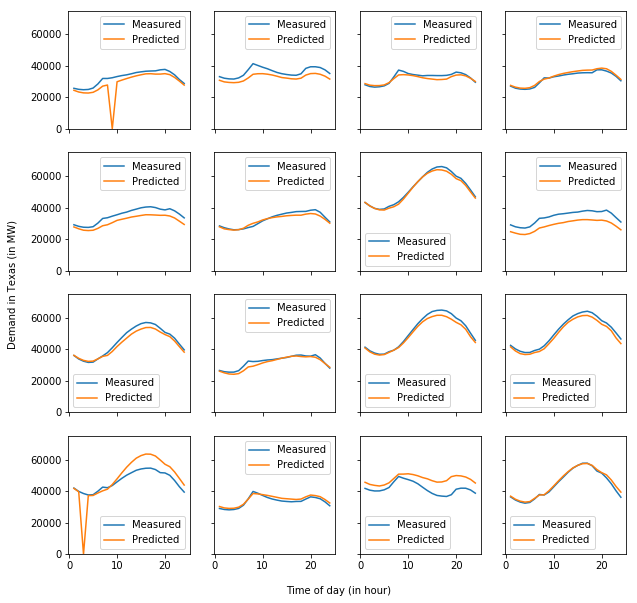

In [9]:
    # Plot the predicted load and compare against the actual load from the test data.
    assert(nTest >= 16)
    days = random.sample(range(nTest), 16)

    fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
    axs = axs.ravel()

    for dd, day in enumerate(days):
        testYDay = testY[day]
        predictedYDay = predictedY[day]

        l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
        l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
        
        axs[dd].set_ylim(bottom=0, top=75000)
        axs[dd].legend()
    
    fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
    fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')
    
    plt.show()

**Question (20 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**Your answer.**
<br>100 Epochs: Mean absolute error of forecast =  14644.421</br> 
<br>1000 Epochs: Average loss in last epoch = 26432251.2 Mean absolute error of forecast =  4772.4805 </br> 
<br>5000 Epochs: Average loss in last epoch = 9548792.6 Mean absolute error of forecast =  2625.5613 </br> 
<br>10000 Epochs: Average loss in last epoch = 12663991.6 Mean absolute error of forecast =  2267.4722 </br> 

As the number of epochs increases, the MEA decreases along with the average loss. This makes sense as the more epochs we give to our network, the more likely the network will be able to converge during the gradient descent (essentially letting the network practice enough times to be at a point where it's able to predict test data accurately). Although at 10,000 epochs shows the best MEA compared to the MEA at other epochs value, the amount that this decreases by is extremely marginal. Additionally, the run time for 10,000 epochs is much longer to 5000 epochs and this may not be worth the trouble as our additional epochs barely reduces the error. Finally, the loss for 10,000 epochs is higher compared to the one at 5000 epochs and this could indicate that we may be overtraining our network as well and this could be harmful when attempting to predict our test data. So 5000 epoch is chosen for having a good runtime along with having a low MEA value. 

**Question (20 points).** Fix the number of echos to your favorite one, and then explore how the number of neurons affects the accuracy and speed of training. Start with 6 , and increase it to 12, 24, 48, 100, and more. Make comments based on your observations. As an engineer, what is your favorite number of neurons, and why? 

**Your answer.**
Using 5000 Epochs: 
<br>6 Neurons: Average loss in last epoch = 228959862.4 Mean absolute error of forecast =  14549.268</br> 
<br>12 Neurons: Average loss in last epoch = 64033273.6 Mean absolute error of forecast =  6485.2363</br> 
<br>24 Neurons: Average loss in last epoch = 31620891.2 Mean absolute error of forecast =  4985.9443</br> 
<br>48 Neurons: Average loss in last epoch = 22696958.0 Mean absolute error of forecast =  3928.2095</br> 
<br>100 Neurons: Average loss in last epoch = 15344249.0 Mean absolute error of forecast =  2833.79</br> 

As the number of neurons (hidden layers) increases, the MEA decreases along with the average loss. This also makes sense as we are allowing the network to be able to spread out the input data into these neurons which allows it to converge onto a value faster during gradient descent. In this case, the 100 Neurons case had the lowest loss and error compared to the other test cases and additionally had a reasonable run time speed as well. Reducing the number of neurons from 100 could have a bigger effect on the networks ability to predict the test data. Thus 100 Neurons will be used in order for the network to have enough hidden layers to make the correct prediction. 

**Question (30 points).** Fix the number of epochs and neurons to your favorite ones. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. If the training becomes too slow, you may alter the number of epochs/neurons. 

**Your answer (comments here, code below). Your code should show the results for the 2 layers case. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons**

In this implementation of the 2 Layer Neural Network, Layer 2 was implemented with the activation function of Relu along with only having 50 neurons. This was done in order to attempt the network in converging onto a specific value more accurately than just using one layer. The resulting MEA was as followed : 

<br>1 Layered Network: Mean absolute error of forecast =  2750.8408 Time: 19.3 seconds</br> 
<br>(100 Neurons) 2 Layered Network: Mean absolute error of forecast =  2268.884 Time: 22.9 </br> 
<br>(50 Neurons)  2 Layered Network: Mean absolute error of forecast =  2197.7456 Time: 20.8 seconds </br>

The 100 Neurons 2 Layered network barely showed any significant change compared to the 1 layered network. While the 50 neuron network ended up doing slightly better than the 1 layered network, this difference is only within the mid 100's to high 100's. Depending on how much cost this can save in the situation provided, the 2 layered network could be used in order to decrease the error. The 1 layered network seems to be able to do the prediction good enough and thus the 2 layed network might be unnecessary in addressing this problem. 

In [71]:
nHidden = 100
nHidden2 = 50 

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights and biases of the first layer.
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.zeros(nHidden))

# Define the output of layer 1. 
outputLayer1 = tf.nn.relu( tf.matmul(inputNN, W1) + b1 )
outputLayer1 = tf.nn.dropout(outputLayer1, 0.995)

# Define the weights and biases of the second layer. 
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nHidden2]))
b2 = tf.Variable(tf.zeros(nHidden2))

# Define the output of layer 2.
outputLayer2 = tf.nn.relu( tf.matmul(outputLayer1, W2) + b2 )
outputNN = tf.nn.dropout(outputLayer2, 0.995)

# Define the weights and biases of the second layer.
W3 = tf.Variable(tf.truncated_normal(shape=[nHidden2, nDimY]))
b3 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 3. 
outputNN = tf.nn.dropout((tf.matmul(outputLayer2, W3) + b3), 0.995)

# Define the loss function and the optimizer.
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.25).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)

In [72]:
%%time 
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5000

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if (epoch + 1) % 200 == 0:
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch + 1, lossEpoch/nBatches))

    print("Training process completed.")
  

Started the training module.
Epoch: 200 - Average loss in last epoch = 18069068.2
Epoch: 400 - Average loss in last epoch = 13772365.6
Epoch: 600 - Average loss in last epoch = 13566590.4
Epoch: 800 - Average loss in last epoch = 12646552.5
Epoch: 1000 - Average loss in last epoch = 13838636.2
Epoch: 1200 - Average loss in last epoch = 13594618.8
Epoch: 1400 - Average loss in last epoch = 11261753.5
Epoch: 1600 - Average loss in last epoch = 8889671.1
Epoch: 1800 - Average loss in last epoch = 12082534.0
Epoch: 2000 - Average loss in last epoch = 12855914.4
Epoch: 2200 - Average loss in last epoch = 10993527.3
Epoch: 2400 - Average loss in last epoch = 10344973.5
Epoch: 2600 - Average loss in last epoch = 7974427.5
Epoch: 2800 - Average loss in last epoch = 10082407.3
Epoch: 3000 - Average loss in last epoch = 10662162.1
Epoch: 3200 - Average loss in last epoch = 11194844.5
Epoch: 3400 - Average loss in last epoch = 9034290.4
Epoch: 3600 - Average loss in last epoch = 8158406.5
Epoch: 

In [73]:
    predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
    print("Mean absolute error of forecast = ", maeOfPrediction)
    print("Maximum Demand: %f" %( np.max(predictedY) ) ) 

Mean absolute error of forecast =  2197.7456
Maximum Demand: 69844.656250


### The effect of wind energy (bonus).

In [74]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
5,1/1/15 5:00,1-Jan,38877,745,12730,1.9,5.9,94.0,14.5
6,1/1/15 6:00,1-Jan,39837,788,12730,2.0,6.2,43.0,5.8
7,1/1/15 7:00,1-Jan,40520,758,12730,1.9,6.0,-30.0,-3.8
8,1/1/15 8:00,1-Jan,41008,668,12730,1.6,5.2,-90.0,-11.8
9,1/1/15 9:00,1-Jan,42052,496,12730,1.2,3.9,-172.0,-25.8


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why? Write down your MAE before and after considering wind energy. 

**Your answer (comments here, code below).**
<br>MEA Before Wind Energy: Mean absolute error of forecast = 2750.8408</br> 
<br>MEA After Subtracting Wind Energy: Mean absolute error of forecast = 2985.5044</br>

The accuracy ends up decreasing when wind energy was taken out from the networks input data. This could be due to the network not being able to account for the exlcusion of the wind output which in turn could affect the prediction. Manipulating the data such as this could end up making the network having a harder time in converging in its gradient descent and additionally being able to learn a pattern from the dataset it was given. 


In [91]:
# This was done by using the 1 Layered Network 

daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]

output = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'Total Wind Output, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]

Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]
output_y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'Total Wind Output, MW'].values.flatten() for day in rangeOfDays]

for i in range(len(X) ) : 
    X[i] = X[i] - output[i]
    
for i in range(len(Y) ) : 
    Y[i] = Y[i] - output_y[i]

X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))

Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


In [92]:
nHidden = 100 

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights and biases of the first layer.
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.zeros(nHidden))

# Define the output of layer 1. 
## use the function 'tf.nn.relu' to define 'OutputLayer1'.  

# ....
outputLayer1 = tf.nn.relu( tf.matmul(inputNN, W1) + b1 )
outputLayer1 = tf.nn.dropout(outputLayer1, 0.995)

# Define the weights and biases of the second layer.
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 2.
outputNN = tf.nn.dropout((tf.matmul(outputLayer1, W2) + b2), 0.995)

# Define the loss function and the optimizer.
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.25).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)

In [93]:
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5000

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if (epoch + 1) % 200 == 0:
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch + 1, lossEpoch/nBatches))

    print("Training process completed.")

Started the training module.
Epoch: 200 - Average loss in last epoch = 110917958.4
Epoch: 400 - Average loss in last epoch = 64168560.8
Epoch: 600 - Average loss in last epoch = 51036341.6
Epoch: 800 - Average loss in last epoch = 47986143.2
Epoch: 1000 - Average loss in last epoch = 34811663.6
Epoch: 1200 - Average loss in last epoch = 33282362.0
Epoch: 1400 - Average loss in last epoch = 30262286.4
Epoch: 1600 - Average loss in last epoch = 27931381.6
Epoch: 1800 - Average loss in last epoch = 25250012.4
Epoch: 2000 - Average loss in last epoch = 24446647.2
Epoch: 2200 - Average loss in last epoch = 23615854.0
Epoch: 2400 - Average loss in last epoch = 18791390.0
Epoch: 2600 - Average loss in last epoch = 19700251.6
Epoch: 2800 - Average loss in last epoch = 17239531.2
Epoch: 3000 - Average loss in last epoch = 17773441.8
Epoch: 3200 - Average loss in last epoch = 18029353.2
Epoch: 3400 - Average loss in last epoch = 14736480.8
Epoch: 3600 - Average loss in last epoch = 20063441.4
Ep

In [94]:
    predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
    print("Mean absolute error of forecast = ", maeOfPrediction)
    print("Maximum Demand: %f" %( np.max(predictedY) ) ) 

Mean absolute error of forecast =  2985.5044
Maximum Demand: 68044.640625
